In [15]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
import pandas as pd

TS = 48 # Time steps

df = pd.read_csv('AusGrid_preprocess.csv', header=[0,1], index_col=0)
df = df.set_index(pd.to_datetime(df.index))
df.columns = df.columns.set_levels(df.columns.levels[0].astype('int64'), level=0)
df = df/2000.
df_date = df.index
df.head()

Customer             1                  3                4                  \
categories            GG     GC     CL   GG     GC   CL   GG     GC     CL   
2012-07-01 00:30:00  0.0  0.855  1.250  0.0  0.965  0.0  0.0  0.084  0.000   
2012-07-01 01:00:00  0.0  0.786  1.250  0.0  0.927  0.0  0.0  0.084  0.000   
2012-07-01 01:30:00  0.0  0.604  1.250  0.0  1.359  0.0  0.0  0.082  1.930   
2012-07-01 02:00:00  0.0  0.544  1.263  0.0  0.060  0.0  0.0  0.084  1.978   
2012-07-01 02:30:00  0.0  0.597  0.131  0.0  0.059  0.0  0.0  0.086  0.784   

Customer             5    ...  297               298         299         300  \
categories            GG  ...   GG     GC    CL   GG     GC   GG     GC   GG   
2012-07-01 00:30:00  0.0  ...  0.0  0.141  0.00  0.0  0.157  0.0  0.541  0.0   
2012-07-01 01:00:00  0.0  ...  0.0  0.257  0.00  0.0  0.127  0.0  0.100  0.0   
2012-07-01 01:30:00  0.0  ...  0.0  0.197  0.00  0.0  0.122  0.0  0.090  0.0   
2012-07-01 02:00:00  0.0  ...  0.0  0.273  1.33  0.0  0.120  0.0  0.094  0.0   
2012-07-01 02:30:00  0.0  ...  0.0  0.206  0.00  0.0  0.106  0.0  0.046  0.0   

Customer                           
categories              GC     CL  
2012-07-01 00:30:00  0.219  2.673  
2012-07-01 01:00:00  0.099  1.246  
2012-07-01 01:30:00  0.134  0.000  
2012-07-01 02:00:00  0.100  0.000  
2012-07-01 02:30:00  0.123  0.000  

[5 rows x 725 columns]

In [17]:
customers = sorted(df.columns.levels[0])
data_train = []
samples = list(range(201, 211)) #[201, 202, 203]

for s in samples:
    train = df[s][['GG', 'GC']]
    train['GC'].values[1]
    print(train.shape)
    data_train.append(train)

(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)
(17520, 2)


State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [18]:
BTMAX = 0.95
BTMIN = 0.10
C_A = 0.01
C_B = 1.
C_C = 0.
R_MAX = 3.

class Environment:
    def __init__(self, data_env, capacity=50.):
        self.capacity = capacity
        self.data_env = data_env
        self.pos = 0
        self.btmax = capacity*BTMAX
        self.btmin = capacity*BTMIN
        self.state = np.array([self.data_env['GG'].values[self.pos], self.data_env['GC'].values[self.pos], 0., 0., self.btmin, 0., 0])

    def reset(self):
        self.state = np.array([0., 0., 0., 0., self.btmin, 0., 0])
        return torch.as_tensor(self.state, dtype=torch.float32).squeeze(0)

    def step(self, action):
        charging = 0.0
        discharging = 0.0
        batt_state = 0.0
        grid_state = 0.0
        reward = 0.

        self.state[0] = self.data_env['GG'].values[self.pos]  # PV generation power
        self.state[1] = self.data_env['GC'].values[self.pos]  # Load consumption power
        
        if action == 1: # charge battery
            charging = max(0, self.state[0] - self.state[1])  # Charging power
            charging = min(self.btmax - self.state[4], charging)
            batt_state = charging # Update battery status
            # if self.state[0] > self.state[1]:
            #     reward = 1.
        elif action == 0: # discharge battery
            discharging = min(max(self.state[4]-self.btmin, 0), max(0, self.state[1] - self.state[0])) # discharing power
            batt_state = -discharging # Update battery status
            # if self.state[0] < self.state[1]:
            #     reward = 1.
            
        grid_state = self.state[1] - (self.state[0] - charging + discharging) # Grid power + : import, - : export
        cost = C_A*grid_state**2 + C_B*abs(grid_state) + C_C
        cost = cost if grid_state > 0 else -cost

        normal_v = abs(self.state[0] - self.state[1])       
        d = abs(grid_state) / normal_v if normal_v else abs(grid_state)
        reward = max((min(3, np.log(1/d)) if d else 3), 0)

        # normal_v2 = C_A*normal_v**2 + C_B*abs(normal_v)
        # d = (abs(cost) - C_C) /normal_v2 if normal_v2 else (abs(cost) - C_C)
        # reward = min(R_MAX, np.log(1/d)) if d else R_MAX
                
        self.state[2] = charging
        self.state[3] = discharging
        self.state[4] += batt_state
        self.state[5] = grid_state
        self.state[6] = cost

        done = ((self.pos + 1) % TS == 0)
        self.pos += 1

        return torch.as_tensor(self.state, dtype=torch.float32), torch.tensor([reward]), done 

    def render(self):
        return 0
    

In [19]:
class A2C(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(A2C, self).__init__()
        self.num_actions = n_actions
        
        self.layer1_actor = nn.Linear(n_observations, 256)
        self.layer1_critic = nn.Linear(n_observations, 256)
        
        self.layer2_actor = nn.Linear(256, 128)
        self.layer2_critic = nn.Linear(256, 128)
        
        self.layer3_actor = nn.Linear(128, n_actions)
        self.layer3_critic = nn.Linear(128, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        px = F.relu(self.layer1_actor(x))
        px = F.relu(self.layer2_actor(px))
        policy_dist = F.softmax(self.layer3_actor(px), dim=-1)

        vx = F.relu(self.layer1_critic(x))
        vx = F.relu(self.layer2_critic(vx))
        value = self.layer3_critic(vx)
        
        return value, policy_dist

In [20]:
BATCH_SIZE = 128
GAMMA = 0.90
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
a2c_net = A2C(n_observaons, n_actions).to(device)
optimizer = optim.Adam(a2c_net.parameters(), lr=1e-4)

7


In [21]:
all_lengths = []
average_lengths = []
all_rewards = []
all_sc_ss = []

entropy_term = 0
    
num_episodes = len(data_train)

for i_episode in range(num_episodes):

    env = Environment(data_train[i_episode%len(data_train)])
    state = env.reset()    

    log_probs = []
    values = []
    rewards = []
    
    total_export = 0.0
    total_import = 0.0
    total_pv = 0.0
    total_ld = 0.0
        
    for i in range(env.data_env.shape[0]):
        value, policy_dist = a2c_net.forward(state)
        value = value.detach().numpy()[0]
        dist = policy_dist.detach().numpy()
        action = np.random.choice(n_actions, p=np.squeeze(dist))
        
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(dist * np.log(dist + 1e-10))
        new_state, reward, done = env.step(action)

        rewards.append(reward.squeeze(0))
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        total_export += state.numpy()[5] if state.numpy()[5] < 0 else 0
        total_import += state.numpy()[5] if state.numpy()[5] > 0 else 0
        total_pv += state.numpy()[0]
        total_ld += state.numpy()[1]

        if done:
            Qval, _ = a2c_net.forward(new_state)
            Qval = Qval.detach().numpy()[0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(i)
            average_lengths.append(np.mean(all_lengths[-10:]))
            # print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(i_episode, np.sum(rewards), i, average_lengths[-1]))

            # compute Q values
            Qvals = np.zeros_like(values)
            for t in reversed(range(len(rewards))):
                Qval = rewards[t] + GAMMA * Qval
                Qvals[t] = Qval

            #update actor critic
            values = torch.FloatTensor(values)
            Qvals = torch.FloatTensor(Qvals)
            log_probs = torch.stack(log_probs)
            
            advantage = Qvals - values
            actor_loss = -(log_probs * advantage).mean()
            critic_loss = 0.5 * advantage.pow(2).mean()
            ac_loss = actor_loss + critic_loss - 0.01 * entropy_term
            print(Qvals.mean(), advantage.mean(), actor_loss.item(), critic_loss.item(), 0.01*entropy_term.item())

            optimizer.zero_grad()
            ac_loss.backward()
            optimizer.step()

            log_probs = []
            values = []
            rewards = []

    sc = (total_pv + total_export)/total_pv
    ss = (total_ld - total_import)/total_ld
    all_sc_ss.append([sc, ss])
    print('sc and ss', sc, ss)


tensor(3.5233) tensor(3.7459) 2.631471872329712 14.529940605163574 0.3317767560482025
tensor(5.0550) tensor(5.2784) 3.6475517749786377 23.64214515686035 0.6638625556230545
tensor(4.7278) tensor(4.9541) 3.389178991317749 16.965078353881836 0.9957178097963333
tensor(3.0929) tensor(3.3132) 2.278615713119507 9.564884185791016 1.327683330178261
tensor(7.1738) tensor(7.4106) 5.270984172821045 38.08226776123047 1.6598357850313188
tensor(2.1354) tensor(2.3527) 1.6311262845993042 5.494126796722412 1.9922709476947784
tensor(5.3227) tensor(5.5456) 3.822450637817383 23.732606887817383 2.324308580160141
tensor(6.0186) tensor(6.2476) 4.2980546951293945 34.47966003417969 2.656740775704384
tensor(7.2173) tensor(7.4611) 5.160529613494873 40.85673141479492 2.988969119787216
tensor(4.0877) tensor(4.3123) 2.992908477783203 14.879240989685059 3.3210163325071336
tensor(0.6434) tensor(0.8603) 0.5841120481491089 0.8019307255744934 3.6528356140851974
tensor(-0.0399) tensor(0.1790) 0.12568891048431396 0.0171755

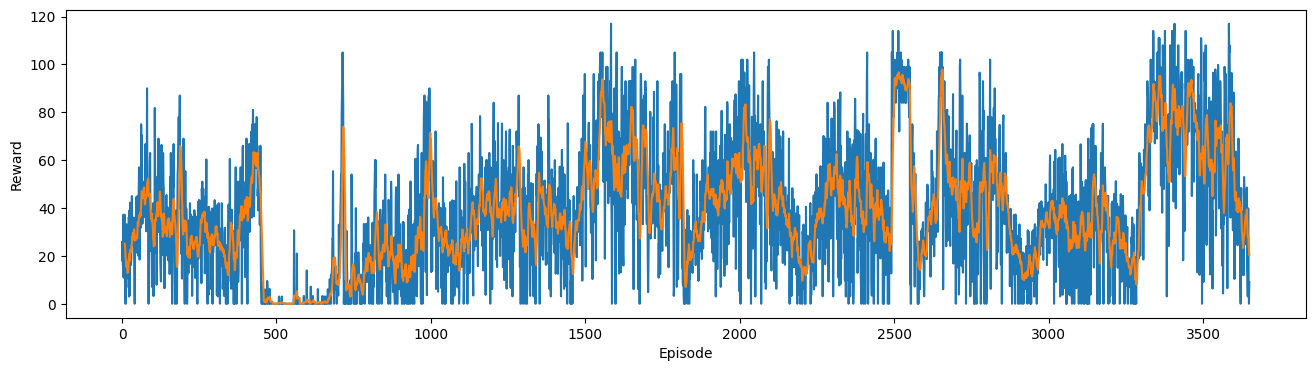

[[0.7563027351159561, 0.2627790066013832], [0.5398718335278049, 0.3131689965791564], [0.7689701012769541, 0.22587626808639097], [0.8529583893070461, 0.4092612607891917], [0.5749088242494204, 0.47625083824424985], [0.7552509416727144, 0.2890898339434984], [0.9159673198536118, 0.3819385797013514], [0.828690092897725, 0.3655644212707915], [0.9351062631483128, 0.2269851004591147], [0.8517794586927714, 0.5108077880742966]]


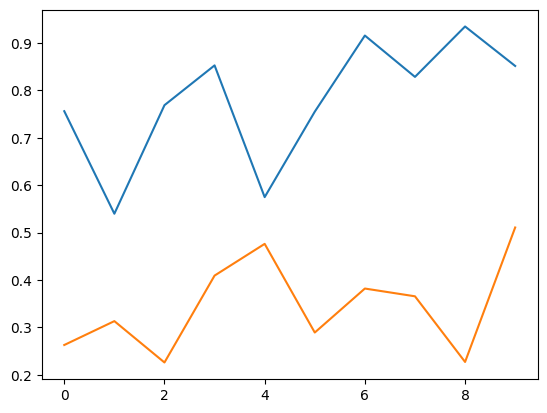

In [22]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.figure(figsize=(16, 4))
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

print(all_sc_ss)
plt.plot(np.array(all_sc_ss)[:, 0])
plt.plot(np.array(all_sc_ss)[:, 1])
plt.show()

In [23]:
customers = sorted(df.columns.levels[0])
data_test = df[1][['GG', 'GC']]
data_test['GC'].values[1]
data_test.shape

(17520, 2)

In [24]:
capacity = 50.
env = Environment(data_test, capacity)
state = torch.tensor(np.array([data_test['GG'].values[0], data_test['GC'].values[0], 0., 0., capacity*BTMIN, 0., 0.0]), dtype=torch.float32).squeeze(0)
df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])
state = state.clone().detach().unsqueeze(0)

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        _, logits = a2c_net.forward(state)
        # prob = F.softmax(logits, dim=1).data
        action = torch.argmax(logits, dim=1).numpy()[0]
        print(logits, action)

        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


tensor([[0.4796, 0.5204]]) 1
tensor([[0.7545, 0.2455]]) 0
tensor([[0.7458, 0.2542]]) 0
tensor([[0.7123, 0.2877]]) 0
tensor([[0.6986, 0.3014]]) 0
tensor([[0.7107, 0.2893]]) 0
tensor([[0.7139, 0.2861]]) 0
tensor([[0.7865, 0.2135]]) 0
tensor([[0.7245, 0.2755]]) 0
tensor([[0.5361, 0.4639]]) 0
tensor([[0.5631, 0.4369]]) 0
tensor([[0.7229, 0.2771]]) 0
tensor([[0.6408, 0.3592]]) 0
tensor([[0.5236, 0.4764]]) 0
tensor([[0.5468, 0.4532]]) 0
tensor([[0.5178, 0.4822]]) 0
tensor([[0.5555, 0.4445]]) 0
tensor([[0.5490, 0.4510]]) 0
tensor([[0.3690, 0.6310]]) 1
tensor([[0.3400, 0.6600]]) 1
tensor([[0.1972, 0.8028]]) 1
tensor([[0.1202, 0.8798]]) 1
tensor([[0.1376, 0.8624]]) 1
tensor([[0.0997, 0.9003]]) 1
tensor([[0.2075, 0.7925]]) 1
tensor([[0.1995, 0.8005]]) 1
tensor([[0.5542, 0.4458]]) 0
tensor([[0.0476, 0.9524]]) 1
tensor([[0.0369, 0.9631]]) 1
tensor([[0.0514, 0.9486]]) 1
tensor([[0.1956, 0.8044]]) 1
tensor([[0.2784, 0.7216]]) 1
tensor([[0.7682, 0.2318]]) 0
tensor([[0.7950, 0.2050]]) 0
tensor([[0.809

                      PV     LD   BT   AC     GD   RD
2012-07-01 00:30:00  0.0  0.855  5.0  0.0  0.855  0.0
2012-07-01 01:00:00  0.0  0.786  5.0 -1.0  0.786  0.0
2012-07-01 01:30:00  0.0  0.604  5.0 -1.0  0.604  0.0
2012-07-01 02:00:00  0.0  0.544  5.0 -1.0  0.544  0.0
2012-07-01 02:30:00  0.0  0.597  5.0 -1.0  0.597  0.0
...                  ...    ...  ...  ...    ...  ...
2012-07-05 22:30:00  0.0  0.414  5.0 -1.0  0.414  0.0
2012-07-05 23:00:00  0.0  0.932  5.0 -1.0  0.932  0.0
2012-07-05 23:30:00  0.0  0.070  5.0 -1.0  0.070  0.0
2012-07-06 00:00:00  0.0  0.094  5.0 -1.0  0.094  0.0
2012-07-06 00:30:00  0.0  0.056  5.0 -1.0  0.056  0.0

[241 rows x 6 columns]


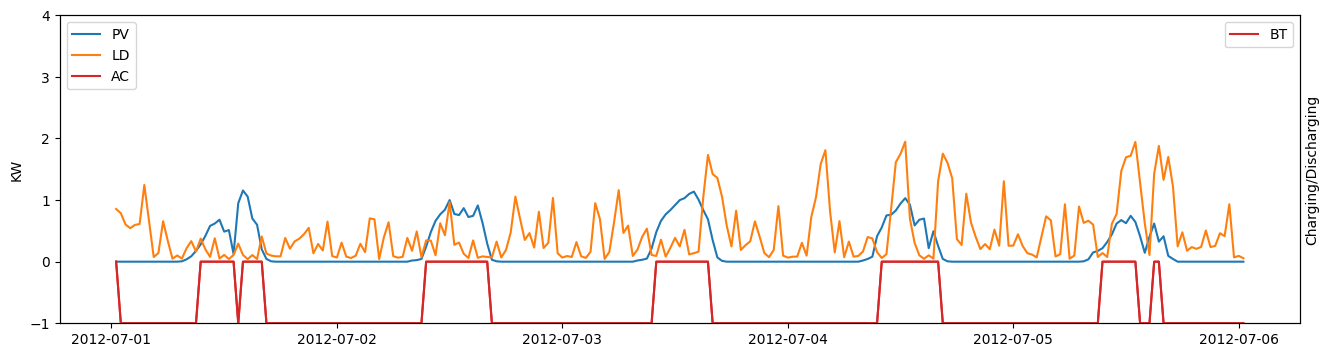

In [25]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

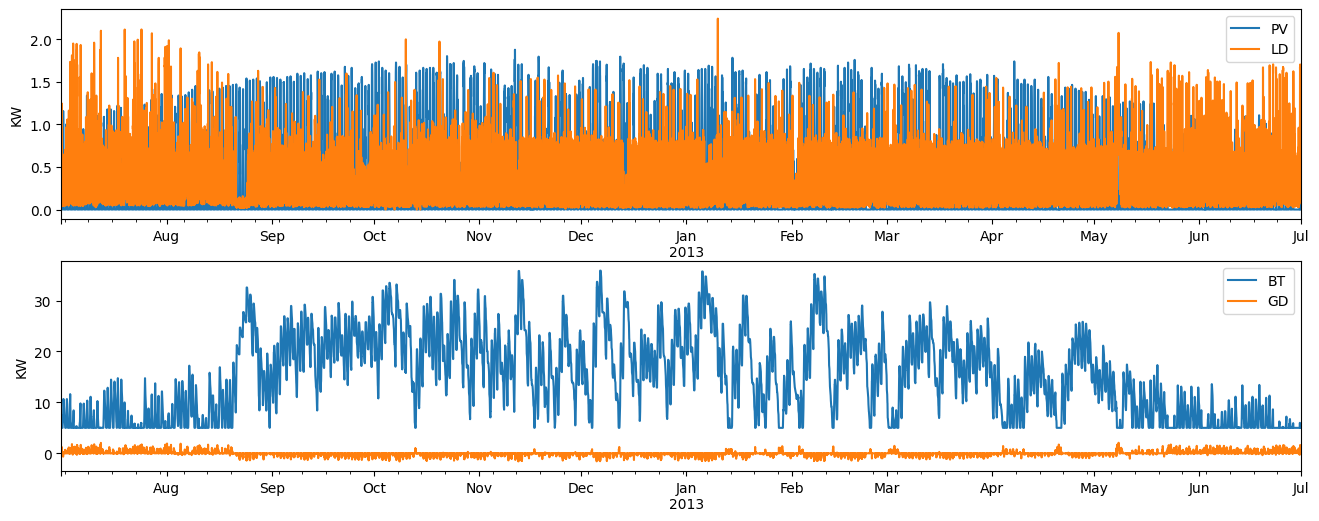

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [27]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Egen + GDexport)/Eload
print('SC :', SC)
print('SS :', SS)

5115.207006187178 KW
5279.884002253413 KW
1119.2200002229074
-954.5429993296275
SC : 0.8133911299826097
SS : 0.788021859018458


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    # ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>